The dataset can be downloaded [here](https://drive.google.com/file/d/1yCe4uyIWUq_cJ9eoFK__KdtoRubrZtx5/view?usp=sharing)

The dataset was retrieved from [kaggle](https://www.kaggle.com/c/fake-news/data)


In [1]:
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, auc

In [2]:
def metrics(y_test, y_pred, cl_probs, clf_used):
    # Prediction metrics
    # Calculate accuracy: (tp + tn)/(tp + tn + fp + fn)
    Accuracy = accuracy_score(y_test, y_pred)
    print(clf_used, 'Accuracy: ', Accuracy * 100, '%', '\n')

    # Calculate confusion matrix
    #           Actual class
    # Predicted [TP, FP]
    # class     [FN, TN]
    Conf_matrix = confusion_matrix(y_test, y_pred, labels = ['FAKE', 'REAL'])
    # Extract true negatives, false positives, false negatives and true positives from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(clf_used, 'Confusion matrix: ' '\n', Conf_matrix, '\n')

    # Calculate precision: tp / (tp + fp)
    precision = tp / (tp + fp)
    print(clf_used, 'Precision: ', precision, '\n')

    # Calculate recall: tp / (tp + fn)
    # True positive rate / Sensitivity
    recall = tp / (tp + fn)
    print(clf_used, 'Recall: ', recall, '\n')

    # Calculate specificity: Tn / (Tn + Fp)
    specificity = tn / (tn+fp)
    print(clf_used, 'Specificity: ', specificity, '\n')

    #Calculate False positive rate
    False_positive_rate = 1 - specificity
    print(clf_used, 'False positive rate: ', False_positive_rate, '\n')

    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(clf_used, 'F1-score: ', f1_score, '\n')

    # Calculate the ROC curve
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    cl_auc = roc_auc_score(y_test, cl_probs)
    print('Random: ROC AUC =', ns_auc)
    print(clf_used, ': ROC AUC =', cl_auc)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label = 'REAL')
    cl_fpr, cl_tpr, _ = roc_curve(y_test, cl_probs, pos_label = 'REAL')
    # Plot the ROC curve
    pyplot.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Random')
    pyplot.plot(cl_fpr, cl_tpr, marker = '.', label = clf_used)
    # Name axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # Show the legend
    pyplot.legend()
    # Show the plot
    pyplot.show()

    # Calculate the precision-recall curve
    cl_precision, cl_recall, _ = precision_recall_curve(y_test, cl_probs, pos_label = 'REAL')
    cl_auc = auc(cl_recall, cl_precision)
    print(clf_used, ': precision-recall auc= ', cl_auc, '\n')
    # Plot the precision-recall curves
    random = len(y_test[y_test == 1]) / len(y_test)
    pyplot.plot([0, 1], [random, random], linestyle='--', label = 'Random')
    pyplot.plot(cl_recall, cl_precision, marker='.', label = clf_used)
    # Name axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # Show the legend
    pyplot.legend()
    # Show the plot
    pyplot.show()

Metrics used to assess classifier prediction.

**Accuracy**: (tp + tn)/(tp + tn + fp + fn). Accuracy is the number of correct predictions / total predictions.

**Confusion matrix**:
               
                   Actual class
        Predicted  TP, FP
        class      FN, TN

**Precision**: tp / (tp + fp). Precision is how close the measured values are to each other.

**Recall**: tp / (tp + fn). Recall quantifies the number of true positive predictions made out of all positive predictions. Recall is also called **sensitivity or true positive rate**.

**Specificity**: Tn / (Tn + Fp). Specificity is the number of true negative predictions made out of all negative predictions.

**False positive rate**: False_positive_rate = 1 - specificity.

**F_score**: 2 * (precision * recall) / (precision + recall). F_score is a harmonic mean between precision and recall.

**Receiver Operator Characteristic**. ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

**Precision-recall curve**. The precision-recall curve shows the tradeoff between precision and recall for different threshold settings. A high area under the curve (auc) represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

In [3]:
# Import dataset in a dataframe
# Pandas.read_csv reads a comma-separated values (csv) file into dataframe and returns a two-dimensional data structure with labeled axes.
dataframe = pd.read_csv(r'C:\Users\dimde\Documents\University of Piraeus - MSc in Artificial Intelligence\Courses\First semester\Machine learning\Assignments\Machine learning\Fake news\Dataset\train.csv')

Reads a comma-separated values (csv) file into Dataframe and returns a two-dimensional data structure with labeled axes.

In [4]:
# Get dataframe information
# Represents the dimensionality of the dataframe
print('Dataframe shape: ', dataframe.shape, '\n')
# Represents the axes of the dataframe
print('Dataframe axes: ', dataframe.axes, '\n')
# Returns the dtypes in the dataframe
print('Dataframe dtypes: ', dataframe.dtypes, '\n')
# Returns an int representing the number of elements in the dataframe
print('Dataframe size: ', dataframe.size, '\n')
# Returns the first 10 rows of the dataframe
print('Dataframe head: ', '\n', dataframe.head(10), '\n')

Dataframe shape:  (20800, 5) 

Dataframe axes:  [RangeIndex(start=0, stop=20800, step=1), Index(['id', 'title', 'author', 'text', 'label'], dtype='object')] 

Dataframe dtypes:  id         int64
title     object
author    object
text      object
label      int64
dtype: object 

Dataframe size:  104000 

Dataframe head:  
    id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

               

Above we retrieve some information of the dataframe.

Firstly, we retrieve the dimensionality of the dataframe. Our dataset has 5 features and 20800 samples.

Then, we get the features of the dataframe. The 5 features are 'id', 'title', 'author', 'text' and 'label'.

Additionally, we extract the dataframe feature sample types (object).

Furthermore, we retrieve the dataframe size. This is the number of elements in the dataframe.

Last but not least, with dataframe.head we view the first 10 rows of the dataframe for analyzation.

Feature description:

* **id**: indicates the index of the article (from 0 to 20799, in total 20800 feature vectors/samples).

* **title**: indicates the title of the article.

* **author**: indicates the author of the article.

* **text**: indicates the actual main body of the article.

* **label**: indicates if the article is fake or not. Value is 0 if the article represents real information and value is 1 if the article represents fake information.

The features that are going to be examined are the features **label** and **text**.

In [5]:
# Convert the 0, 1 labels to 'REAL' and 'FAKE' for simplicity
# With Dataframe.loc set value for an entire column
dataframe.loc[(dataframe['label'] == 1) , ['label']] = 'FAKE'
dataframe.loc[(dataframe['label'] == 0) , ['label']] = 'REAL'

For our better visualization convert feature label values "0" to "REAL" and "1" to "FAKE". This is only done for comprehension.

In [6]:
# Visualize the head again to check the label changes
print('Converted dataframe head: ', '\n', dataframe.head(10), '\n')

Converted dataframe head:  
    id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

                         author  \
0                 Darrell Lucus   
1               Daniel J. Flynn   
2            Consortiumnews.com   
3               Jessica Purkiss   
4                Howard Portnoy   
5               Daniel Nussbaum   
6                           NaN   
7               Alissa J. Rubi

Now the feature label presents the 0 values with "REAL" and the 1 values with "FAKE".

In [7]:
# Isolate the text and label feature columns from the rest of the dataframe
labels = dataframe.label
labels.head()
text = dataframe.text
text.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    Ever get the feeling your life circles the rou...
2    Why the Truth Might Get You Fired October 29, ...
3    Videos 15 Civilians Killed In Single US Airstr...
4    Print \nAn Iranian woman has been sentenced to...
Name: text, dtype: object

Isolate the text and label from the dataframe so that we use it for classification.

In [8]:
# Split the dataset with train test split
# Tested for different case scenarios
x_train,x_test,y_train,y_test = train_test_split(text.values.astype('str'), labels, test_size = 0.2, random_state = 7)

The sklearn **train_test_split** function will be used for spliting the dataset.

The reason we split the dataset is because we can't use the same data for prediction that we used for training. If we do this then our prediction evaluation will be biased. We need to evaluate our prediction based on "unseen" data by the model.

In order to have an unbiased prediction evaluation, spliting the dataset is essential. The dataset is also shuffled before applying the split. Furthermore, It is randomized during spliting.

As can be seen above, different case scenarios were used for training, testing and spliting the data. Highest accuracy scenario was using 80% of the dataset for train and 20% of the dataset for testing.

## train_test_split parameters

* **train_size**: is the number that defines the size of the training set.

* **test_size**: is the number that defines the size of the test set.

* **random_state**: is the object that controls randomization during splitting. It can be either an int or an instance of RandomState. The default value is None.

* **shuffle**: is the object (Τrue by default) that determines whether to shuffle the dataset before applying the split.

* **stratify**: is an array-like object that, if not None, determines how to use a stratified split.


In [9]:
# Custom stop words list
stop_words_list = ['a, the, of, this, that, if, until, thereafter, after, an']
# Initialize a TfidfVectorizer
# Tested for different case scenarios
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7, max_features = 1000)

## Bag-of-words model

The **bag-of-words model** is a method of representing text data when modeling text with machine learning algorithms. It is easy to comprehend and implement and has seen huge success in applications such as language modeling and document classification.

An issue with modeling text is that it is disorganized, and methods like machine learning algorithms fancy defined fixed-length inputs and outputs. Since machine learning algorithms cannot operate with text directly, the text must be changed into vectors of numbers. Therefore we do feature encoding with the bag-of-words model of text. It is a well liked and plain method of feature encoding with text.

The method is simple and adaptable and can be used in a lot of ways for pulling out features from documents. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

* A vocabulary of known words.
* A measure of the presence of known words.

The order of occurrence is not important. We only care about whether known words occur in the document. The bag-of-words approach, looks at the histogram of the words within the text.

The objective is to transform each document of free text into a vector that we can use as input or output for a machine learning model. The simplest scoring method is to mark the presence of words as 0 for absent, and 1 for present. New documents that overlap with the vocabulary of known words, but may include words outside of the vocabulary, can still be encoded, where only the occurrence of known words are scored and unknown words are ignored.

In this assignment each article is a "document" and all of the articles together are the entire corpus of "documents". An entire corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

For a very large corpus, such as thousands of books, the length of the vector might be thousands or millions of positions. Furthermore, each document may include very few of the known words in the vocabulary. This results in a vector with lots of zero scores, called a sparse vector or sparse representation. Sparse vectors require more memory and computational resources when modeling and the vast number of positions or dimensions can make the modeling process very challenging for traditional algorithms. Therefore, there is need to decrease the size of the vocabulary when using a bag-of-words model.

There are some techniques that can be used as a first step to reduce the size of the vocabulary. For example:

* ignoring uppercase and lowercase in words.
* ignoring punctuation.
* ignoring frequent words that don’t contain much information (called stop words) like "a", "of", "him", "the".
* fixing misspelled words.
* reducing words to their stem using stemming algorithms (for example "use" from "using").

A more sophisticated approach is to create a vocabulary of grouped words. This changes the scope of the vocabulary and also allows the bag-of-words to capture somewhat more meaning from the document. By doing this, each word or token is called a **gram**. Creating a vocabulary of two-word pairs is called a **2-gram model** or a **bigram model**. As a result, only the bigrams that appear in the corpus are modeled, not all possible bigrams. A **3-gram model** or a trigram is a three-word sequence of words. The general approach is called the **n-gram model**, where n refers to the number of grouped words. Often a simple bigram approach is better than a 1-gram bag-of-words model for tasks like documentation classification.

Once a vocabulary method has been chosen, the occurrence of words in the documents needs to be scored. As mentioned earlier, the simplest scoring method is binary scoring which marks the presence of words as 0 for absent, and 1 for present. Another scoring method is counts, which counts the number of times each word appears in a document. Additionally, frequencies scoring method calculates the frequency that each word appears in a document out of all the words in the document.

Feature hashing is when known words use a hash representation in the vocabulary. This addresses the problem of having a very large vocabulary for a large text corpus because then the size of the hash space can be defined, which is in turn the size of the vector representation of the document. Words are hashed deterministically to the same integer index in the target hash space. A binary score or count can then be used to score the word. The challenge is to choose a hash space to accommodate the chosen vocabulary size to minimize the probability of collisions and trade-off sparsity.

## TF-IDF

A problem with scoring word frequency is that highly frequent words start to dominate in the document (for example, larger score), but may not contain as much "information" to the model as more rare but perhaps domain specific words.

One approach is to rescale the frequency of words by how often they appear in entire corpus of documents, so that the scores for frequent words like "the" that are also frequent across all documents are penalized. This approach to scoring is called "Term Frequency–Inverse Document Frequency", or TF-IDF for short, where:

* Term Frequency is a scoring of the frequency of the word in the current document.
* Inverse Document Frequency is a scoring of how rare the word is across documents.

The scores are a weighting where not all words are equally as important or interesting. The scores have the effect of highlighting words that are distinct (contain useful information) in a given document. Thus, the IDF of a rare term is high, whereas the IDF of a frequent term is likely to be low.

The bag-of-words model is very simple to understand and implement and offers a lot of flexibility for customization on specific text data. It has been used with great success on prediction problems like language modeling and documentation classification. Nevertheless, it suffers from some drawbacks, such as:

* Vocabulary: The vocabulary requires careful design, most specifically in order to manage the size, which impacts the sparsity of the document representations.
* Sparsity: Sparse representations are harder to model both for computational reasons (space and time complexity) and also for information reasons, where the challenge is for the models to harness so little information in such a large representational space.
* Meaning: Discarding word order ignores the context, and in turn meaning of words in the document (semantics). Context and meaning can offer a lot to the model, that if modeled could tell the difference between the same words differently arranged (“this is interesting” as opposed to “is this interesting”), synonyms (“old bike” vs “used bike”), and many more semantics.

## TfidfVectorizer parameters

Declare a TfidfVectorizer using stop words from the English language and allow up to an article frequency of 0.7.

**stop_words**: If a string, it is passed to _check_stop_list and the appropriate stop list is returned. ‘english’ is currently the only supported string value. There are several known issues with ‘english’. See below.

Using stop words Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality.

There are several known issues in our provided ‘english’ stop word list. It does not aim to be a general, ‘one-size-fits-all’ solution as some tasks may require a more custom solution.

Please take care in choosing a stop word list. Popular stop word lists may include words that are highly informative to some tasks, such as computer.

You should also make sure that the stop word list has had the same preprocessing and tokenization applied as the one used in the vectorizer. The word we’ve is split into we and ve by CountVectorizer’s default tokenizer, so if we’ve is in stop_words, but ve is not, ve will be retained from we’ve in transformed text. Our vectorizers will try to identify and warn about some kinds of inconsistencies.

**max_df**: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float in range (0.0 , 1.0), the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**lowercase**: Convert all characters to lowercase before tokenizing.

**ngram_range**: The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.

**max_features**: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. This parameter is ignored if vocabulary is not None.


In [10]:
# Fit and transform train set and test set to TfidfVectorizer
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

# View vocabulary length
vocabulary_len = len(tfidf_vectorizer.get_feature_names())
print('TfidfVectorizer number of features: ', vocabulary_len, '\n')

# Visualize the stop words used by TfidfVectorizer
stop_words_len = tfidf_vectorizer.get_stop_words()
print('TfidfVectorizer stop words: ', '\n', stop_words_len, '\n')

TfidfVectorizer number of features:  1000 

TfidfVectorizer stop words:  
 frozenset({'next', 'whereas', 'same', 'it', 'ours', 'him', 'may', 'beforehand', 'someone', 'no', 'often', 'become', 'up', 'sixty', 'give', 'through', 'thereupon', 'after', 'by', 'part', 'i', 'why', 'might', 'call', 'even', 'thru', 'nowhere', 'below', 'last', 'under', 'am', 'have', 'alone', 'found', 'our', 'afterwards', 'too', 'etc', 'can', 'above', 'whose', 'seem', 'two', 'third', 'namely', 'cry', 'is', 'herein', 'ten', 'perhaps', 'else', 'amount', 'all', 'your', 'toward', 'since', 'couldnt', 'meanwhile', 'another', 'un', 'see', 'much', 'either', 'whereupon', 'twenty', 'us', 'nothing', 'mill', 'at', 'these', 'hereafter', 'get', 'in', 'whither', 'otherwise', 'other', 'should', 'whence', 'four', 'well', 'they', 'hundred', 'across', 'she', 'please', 'noone', 'who', 'several', 'first', 'during', 'themselves', 'inc', 'latter', 'himself', 'moreover', 'on', 'whether', 'their', 'a', 'yours', 'and', 'somewhere', 'also', 

Fit the training and test set on the TfidfVectorizer.
Furthermore, visualize the stop words and the vocabulary to have an idea which usual words the vectorizer leaves out. A custom word list was also used for testing.

In [11]:
# Initialize kfold cross-validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)

Cross validation is an important concept in machine learning. It is a way to check if overfitting occurs and also helps tune the hyperparameters. In order to find the best parameters for a classifier we cross validate the training data.

Use a 10-fold cross validation. Use it to estimate the skill of a machine learning model on unseen data.

Logistic regression cross validation mean accuracy:  93.203125 % 

Logistic regression Accuracy:  93.5576923076923 % 

Logistic regression Confusion matrix: 
 [[1982  118]
 [ 150 1910]] 

Logistic regression Precision:  0.9418145956607495 

Logistic regression Recall:  0.9271844660194175 

Logistic regression Specificity:  0.9438095238095238 

Logistic regression False positive rate:  0.056190476190476235 

Logistic regression F1-score:  0.9344422700587085 

Random: ROC AUC = 0.5
Logistic regression : ROC AUC = 0.9853823393435045


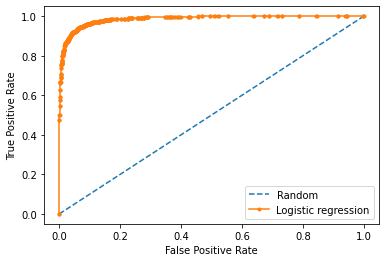

Logistic regression : precision-recall auc=  0.9857689960715394 



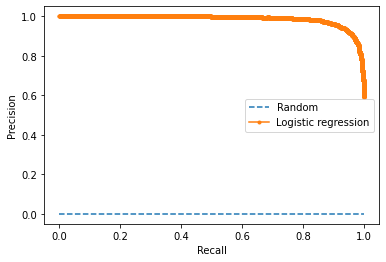

In [12]:
# Initialize the LogisticRegression classifier and fit training sets
clf = LogisticRegression()
clf.fit(tfidf_train, y_train)
# Get probability estimates for the x_test for ROC
cl_probs = clf.predict_proba(tfidf_test)
cl_probs = cl_probs[:, 1]
# Predict with Logistic Regression classifier
y_pred = clf.predict(tfidf_test)
clf_used = 'Logistic regression'
# Evaluate model
scores = cross_val_score(clf, tfidf_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(clf_used, 'cross validation mean accuracy: ', scores.mean() * 100, '%', '\n')
log_reg_metrics = metrics(y_test, y_pred, cl_probs, clf_used)

Predict with logistic regression. The cross validation accuracy is similar to the predicted accuracy. Therefore we assume that no overfitting occurs. Overall logistic regression provided the best results compared to other classifiers that were tested.

Multinomial naive bayes cross validation mean accuracy:  87.76442307692308 % 

Multinomial naive bayes Accuracy:  87.21153846153847 % 

Multinomial naive bayes Confusion matrix: 
 [[1752  348]
 [ 184 1876]] 

Multinomial naive bayes Precision:  0.8435251798561151 

Multinomial naive bayes Recall:  0.9106796116504854 

Multinomial naive bayes Specificity:  0.8342857142857143 

Multinomial naive bayes False positive rate:  0.1657142857142857 

Multinomial naive bayes F1-score:  0.8758169934640523 

Random: ROC AUC = 0.5
Multinomial naive bayes : ROC AUC = 0.9601842348589922


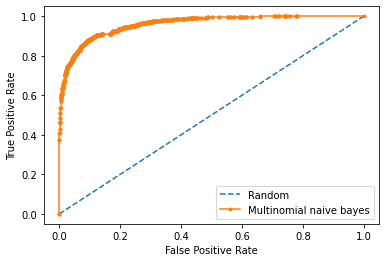

Multinomial naive bayes : precision-recall auc=  0.9626972992054416 



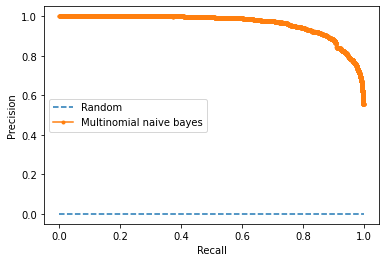

In [13]:
# Initialize the Multinomial Naive Bayes classifier and fit training sets
clf = MultinomialNB()
clf.fit(tfidf_train, y_train)
# Get probability estimates for the x_test for ROC
cl_probs = clf.predict_proba(tfidf_test)
cl_probs = cl_probs[:, 1]
# Predict with Multinomial Naive Bayes classifier
y_pred = clf.predict(tfidf_test)
clf_used = 'Multinomial naive bayes'
# Evaluate model
scores = cross_val_score(clf, tfidf_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(clf_used, 'cross validation mean accuracy: ', scores.mean() * 100, '%', '\n')
naive_bayes_metrics = metrics(y_test, y_pred, cl_probs, clf_used)

Predict with Multinomial Naive Bayes. Compared to logistic regression, naive bayes performs worse when it comes to prediction. Naive bayes provided a statistically low true positive rate. It is worthy to note that naive bayes is fast.

k-nearest neighbors cross validation mean accuracy:  72.51802884615385 % 

k-nearest neighbors Accuracy:  73.72596153846153 % 

k-nearest neighbors Confusion matrix: 
 [[1994  106]
 [ 987 1073]] 

k-nearest neighbors Precision:  0.9100932994062765 

k-nearest neighbors Recall:  0.5208737864077669 

k-nearest neighbors Specificity:  0.9495238095238095 

k-nearest neighbors False positive rate:  0.05047619047619045 

k-nearest neighbors F1-score:  0.6625501698054955 

Random: ROC AUC = 0.5
k-nearest neighbors : ROC AUC = 0.7953257050392972


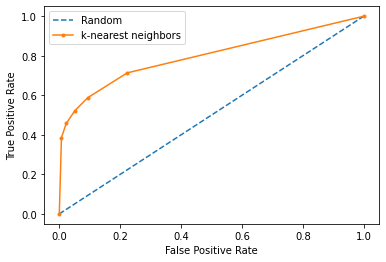

k-nearest neighbors : precision-recall auc=  0.8511050998759289 



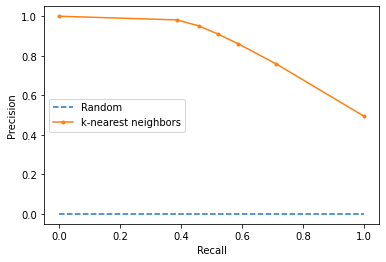

In [14]:
# Initialize the KNeighborsClassifier classifier and fit training sets
clf = KNeighborsClassifier()
clf.fit(tfidf_train, y_train)
# Get probability estimates for the x_test for ROC
cl_probs = clf.predict_proba(tfidf_test)
cl_probs = cl_probs[:, 1]
# Predict with KNeighborsClassifier classifier
y_pred = clf.predict(tfidf_test)
clf_used = 'k-nearest neighbors'
# Evaluate model
scores = cross_val_score(clf, tfidf_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(clf_used, 'cross validation mean accuracy: ', scores.mean() * 100, '%', '\n')
k_neighbors_metrics = metrics(y_test, y_pred, cl_probs, clf_used)

Predict with K nearest neighbor. K nearest neighbor provided the worse results. The true positive rate is very low.

Decision tree cross validation mean accuracy:  87.75841346153847 % 

Decision tree Accuracy:  87.6201923076923 % 

Decision tree Confusion matrix: 
 [[1827  273]
 [ 242 1818]] 

Decision tree Precision:  0.8694404591104734 

Decision tree Recall:  0.8825242718446602 

Decision tree Specificity:  0.87 

Decision tree False positive rate:  0.13 

Decision tree F1-score:  0.875933509997591 

Random: ROC AUC = 0.5
Decision tree : ROC AUC = 0.87482582061951


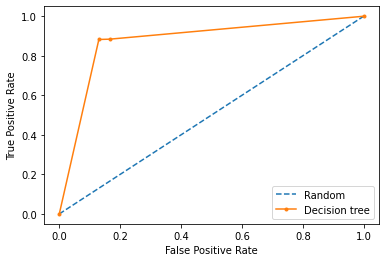

Decision tree : precision-recall auc=  0.9036088938700693 



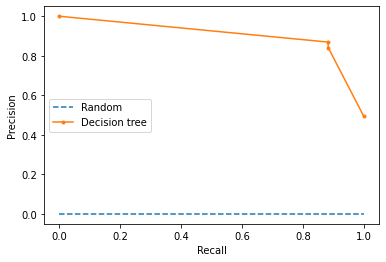

In [15]:
# Initialize the DecisionTreeClassifier and fit training sets
clf = DecisionTreeClassifier()
clf.fit(tfidf_train, y_train)
# Get probability estimates for the x_test for ROC
cl_probs = clf.predict_proba(tfidf_test)
cl_probs = cl_probs[:, 1]
# Predict with DecisionTreeClassifier
y_pred = clf.predict(tfidf_test)
clf_used = 'Decision tree'
# Evaluate model
scores = cross_val_score(clf, tfidf_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(clf_used, 'cross validation mean accuracy: ', scores.mean() * 100, '%', '\n')
decision_tree_metrics = metrics(y_test, y_pred, cl_probs, clf_used)

Predict with Decision tree. Decision tree results are quite similar to naive bayes.